# EEG Analysis with MNE python 

the notebook covers the basic EEG/MEG pipeline for event-related analysis: loading data, epoching , averaging, and estimating cortical activity from sensor data 

In [1]:
import os 
import numpy as np 
import mne 

## Loading data 

In [3]:
# navigating the folder with the "sample" dataset
sample_data_folder = mne.datasets.sample.data_path()

# finding the file location
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample', 'sample_audvis_filt-0-40_raw.fif')

# locating the sample file 
raw = mne.io.read_raw_fif(sample_data_raw_file)

Opening raw data file /home/achintya/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


In [4]:
# Checking out the details of the dataset

print(raw)

# The info data structure keeps track of channel locations, applied filters, projectors, etc.
print(raw.info)

<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~3.3 MB, data not loaded>
<Info | 15 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 GRAD, 102 MAG, 9 STIM, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off, Average EEG reference: off
 sfreq: 150.2 Hz
>


Effective window size : 13.639 (s)
Effective window size : 13.639 (s)
Effective window size : 13.639 (s)


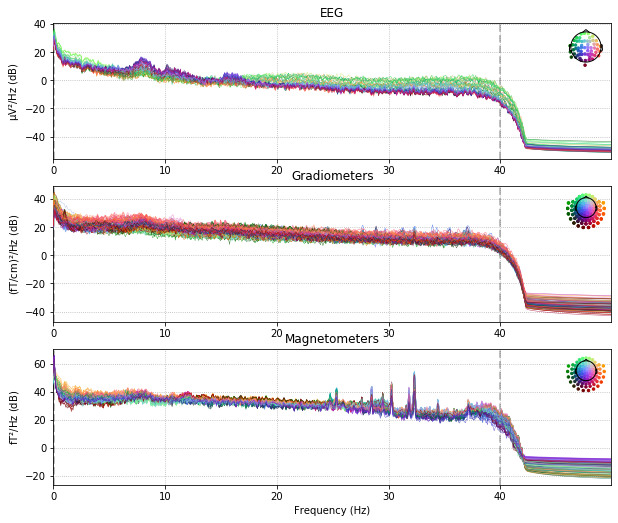

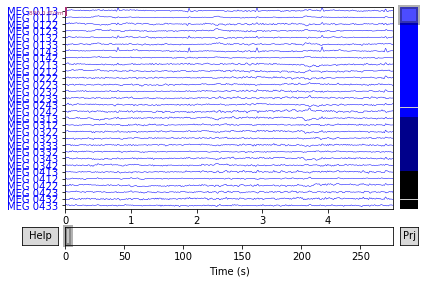

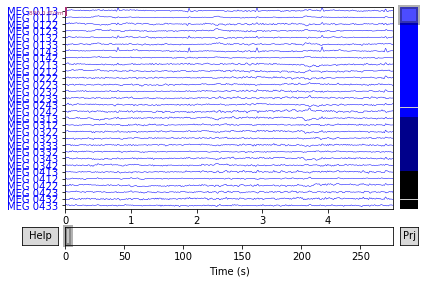

In [5]:
# Raw objects also have several built in plotting methods;
# for example power spectral density 
# plotting only frequencies below 50 hz 

raw.plot_psd(fmax=50)
raw.plot(duration=5, n_channels=30)

## Preprocessing 

MNE-python supports a variety of preprocessing approaches and techniques like - 
1. maxwell filtering 
2. signal space projection 
3. independent components analysis 
4. filtering 
5. downsampling 
etc.. 

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 11.8s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


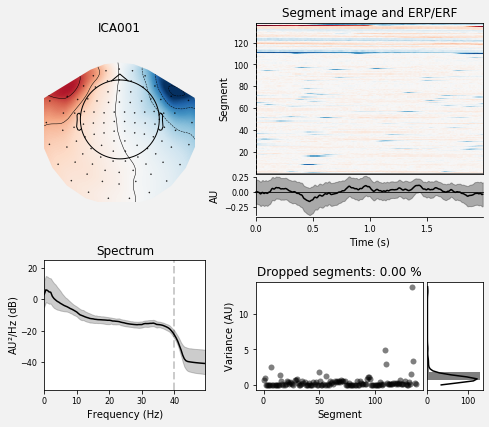

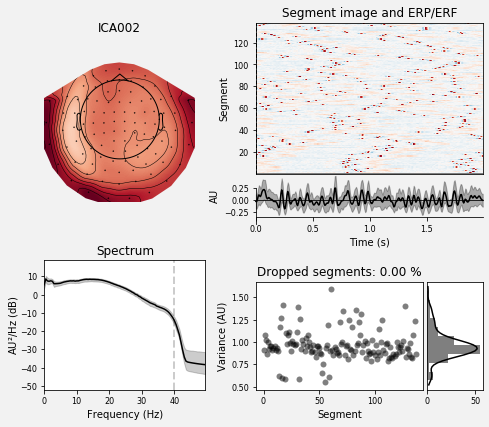

[<Figure size 504x432 with 6 Axes>, <Figure size 504x432 with 6 Axes>]

In [6]:
# Performing cleaning up the data using independent component analysis 
# set up and fit the ICA 

ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1,2] 
ica.plot_properties(raw, picks=ica.exclude)

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components


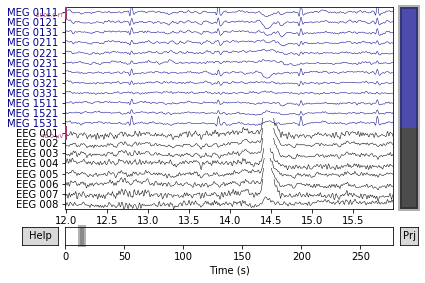

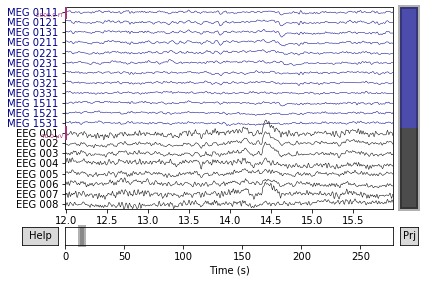

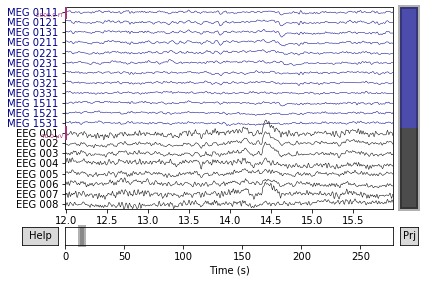

In [7]:
# When we are confident about the components we want to remove, we pass them
# as exclude parameter and then aply the ICA to the raw signal 

orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

# show some frontal channels to clearly illustrate the artifact removal
chs = ['MEG 0111', 'MEG 0121', 'MEG 0131', 'MEG 0211', 'MEG 0221', 'MEG 0231',
       'MEG 0311', 'MEG 0321', 'MEG 0331', 'MEG 1511', 'MEG 1521', 'MEG 1531',
       'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006',
       'EEG 007', 'EEG 008']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)

## Detecting experimental events 

The sample dataset includes STIM channels that recorded the stimulus delivery computer.  These pulses (often called “triggers”) are used in this dataset to mark experimental events: stimulus onset, stimulus type, and participant response (button press). 

In [8]:
# recovering the timing and identity of the stimulus events 

events = mne.find_events(raw, stim_channel='STI 014')
print(events[:5])  # show the first 5

319 events found
Event IDs: [ 1  2  3  4  5 32]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


Rather than keeping track of integer event IDs, we can provide event dictionary that maps the integer ids to experimental conditions or events. numbers with experimental events are below - 
1. auditory stimulus (tone) to the left ear

2. auditory stimulus (tone) to the right ear

3. visual stimulus (checkerboard) to the left visual field

4. visual stimulus (checkerboard) to the right visual field

5. smiley face (catch trial)<br>32 subject button press

In [9]:
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4, 'smiley': 5, 'buttonpress': 32}


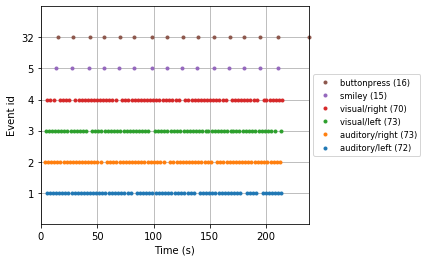

In [10]:
# plotting the event detection with respect to time 
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp)
